# Begin visualisations

In [1]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c

In [2]:
working = Path('..')
working

PosixPath('..')

In [3]:
!pwd

/Users/Jon/Developer/Github/dh-trace/notebooks


In [4]:
!ls $working

LICENSE                   hapaxes_1tM.py            make_histogram.py
Project History.pdf       init_db.py                make_jumbo_dash.py
README.md                 load_alignments.py        make_lines.py
__pycache__               load_authors_and_texts.py notebooks
arch                      load_hapax_intersects.py  poetry.lock
authors.txt               load_hapaxes.py           predict_ops.py
auto_author_prediction.py load_jaccard.py           projects
begin.sh                  load_ngram_intersects.py  pyproject.toml
database_ops.py           load_ngrams.py            requirements.txt
dh-trace-venv             load_relationships.py     show_previous_averages.py
diagrams.ipynb            make_3d_plot.py           util.py
do_svm.py                 make_auto_scatterplot.py  utils
do_viz.sh                 make_confusion.py
explore                   make_dash.py


In [5]:
things = working.glob('*')

In [6]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../__pycache__
../load_hapaxes.py
../Project History.pdf
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../.venv
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [7]:
project_name = 'sm-test'
project_path = working / 'projects' / project_name

In [8]:
project_path

PosixPath('../projects/sm-test')

In [9]:
db_path = project_path / 'db' / f'{project_name}.db'
db_path

PosixPath('../projects/sm-test/db/sm-test.db')

In [10]:
db_path.exists()

True

In [11]:
EDGES_QUERY = """
SELECT 
    calculation.pair_id,
    round(calculation.comp_score, 3) as comp_score,
    threshold,
    weight.weight_id,
    weight.hap_weight,
    weight.al_weight,
    weight.svm_weight,
    text_pair.text_a AS a_text_id,
    text_pair.text_b AS b_text_id,
    text_a.source_filename AS a_text_filename,
    text_b.source_filename AS b_text_filename,
    dir_a.id AS a_work_dir_id,
    dir_b.id AS b_work_dir_id,
    dir_a.dir AS a_work,
    dir_b.dir AS b_work,
    text_a.author_id AS a_author_id,
    text_b.author_id AS b_author_id,
    calculation.same_author,
    author_a.author_name AS a_author,
    author_b.author_name AS b_author
FROM calculations AS calculation
    JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
    JOIN weights AS weight ON weight.weight_id = calculation.weight_id
    JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
    JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
    JOIN dirs AS dir_a ON dir_a.id = text_a.dir
    JOIN dirs AS dir_b ON dir_b.id = text_b.dir
    JOIN authors AS author_a ON author_a.id = text_a.author_id
    JOIN authors AS author_b ON author_b.id = text_b.author_id
    -- WHERE -- calculation.weight_id = 10
    -- AND threshold = 0.75
    -- AND a_author_id <> b_author_id
    ORDER BY pair_id
    -- LIMIT 10
"""
#add LIMIT 10 at bottom to limit results to first 10

In [12]:
EDGES_QUERY

'\nSELECT \n    calculation.pair_id,\n    round(calculation.comp_score, 3) as comp_score,\n    threshold,\n    weight.weight_id,\n    weight.hap_weight,\n    weight.al_weight,\n    weight.svm_weight,\n    text_pair.text_a AS a_text_id,\n    text_pair.text_b AS b_text_id,\n    text_a.source_filename AS a_text_filename,\n    text_b.source_filename AS b_text_filename,\n    dir_a.id AS a_work_dir_id,\n    dir_b.id AS b_work_dir_id,\n    dir_a.dir AS a_work,\n    dir_b.dir AS b_work,\n    text_a.author_id AS a_author_id,\n    text_b.author_id AS b_author_id,\n    calculation.same_author,\n    author_a.author_name AS a_author,\n    author_b.author_name AS b_author\nFROM calculations AS calculation\n    JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id\n    JOIN weights AS weight ON weight.weight_id = calculation.weight_id\n    JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a\n    JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b\n    JOIN dirs AS dir

In [13]:
con = sqlite3.connect(db_path)

In [14]:
#creates a view of the extensive query above and lets me work with it as if it's a tables
with suppress(OperationalError):
    con.execute(f"""
    CREATE VIEW edges
    AS
    {EDGES_QUERY}
    """)
#TODO - check suppression of errors

In [15]:
#specify weight and threshold for SQL call
weight_value = 10
threshold_value = 0.9

#Actually run the query
query = f"""
SELECT * 
FROM edges 
WHERE a_work_dir_id <> b_work_dir_id
AND weight_id = {weight_value} 
AND threshold = {threshold_value}
-- LIMIT 1000
"""
print(query)


SELECT * 
FROM edges 
WHERE a_work_dir_id <> b_work_dir_id
AND weight_id = 10 
AND threshold = 0.9
-- LIMIT 1000



In [16]:
edges_df = pd.read_sql(query, con)
print(f"{len(edges_df):,}")

2,941


In [17]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 

edges_df = edges_df.sample(1000)
print(len(edges_df))
min_comp_score = edges_df['comp_score'].min() 
max_comp_score = edges_df['comp_score'].max() 
print(min_comp_score, max_comp_score)

1000
0.756 0.987


In [18]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [19]:
print(edges_df.sample(n=10))

      pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
504     15941       0.808        0.9         10       0.225       0.55   
2049   152240       0.807        0.9         10       0.225       0.55   
1548   113705       0.966        0.9         10       0.225       0.55   
69       2545       0.836        0.9         10       0.225       0.55   
2701   189564       0.784        0.9         10       0.225       0.55   
2661   187931       0.787        0.9         10       0.225       0.55   
1881   142217       0.962        0.9         10       0.225       0.55   
2690   188776       0.788        0.9         10       0.225       0.55   
2650   187717       0.783        0.9         10       0.225       0.55   
1957   147697       0.964        0.9         10       0.225       0.55   

      svm_weight  a_text_id  b_text_id                     a_text_filename  \
504        0.225        569        530   1840-ENG18400—Trollope-chapter_31   
2049       0.225        397  

In [20]:
G

In [21]:
TEXT_FONT_SIZE = 8

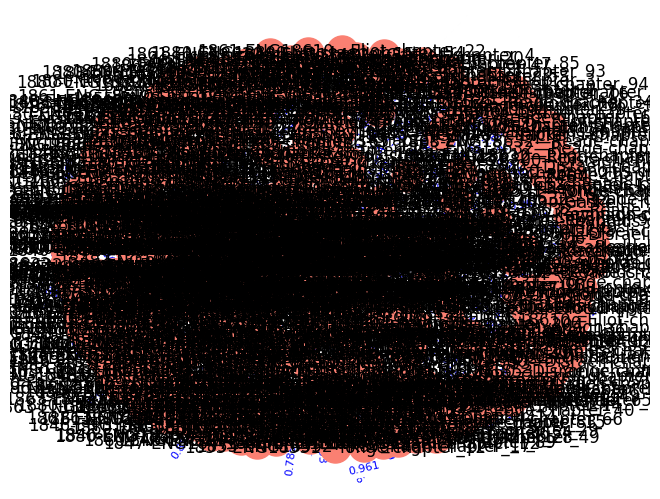

In [22]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

 # Draw nodes with labels
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [23]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)


In [24]:
#this is so we can programmatically edit and choose variables for the graph

def build_style(color_threshold):
    return [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'label': 'data(id)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'color': 'blue',
                 'label': 'data(comp_score)',
                'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
                 #'width': '10px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            }
        }, 
        {
            "selector": f"edge[comp_score>{color_threshold}]",
            "style": {
                "line-color": "red",
            }
        },
    ]
style = build_style(0.92)
pprint(style)
C.set_style(style)

[{'selector': 'node',
  'style': {'background-color': 'salmon',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(id)'}},
 {'selector': 'edge',
  'style': {'color': 'blue',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(comp_score)',
            'line-color': 'black',
            'width': 'mapData(comp_score, 0.756, 0.987, 1, 10)'}},
 {'selector': 'edge.directed',
  'style': {'curve-style': 'bezier',
            'target-arrow-color': 'black',
            'target-arrow-shape': 'triangle'}},
 {'selector': 'edge[comp_score>0.92]', 'style': {'line-color': 'red'}}]


In [25]:
#make slider

caption = widgets.Label(value='The slider value is in its initial position.')

slider = widgets.IntSlider(
    value=90,
    min=90,
    max=100,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def handle_slider_change(change):
    color_threshold = change.new / 100
    caption.value = f"The slider value is: {color_threshold}"
    style = build_style(color_threshold=color_threshold)
    C.set_style(style)
    
slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='The slider value is in its initial position.')

IntSlider(value=90, continuous_update=False, description='Test:', min=90)

In [26]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS

 ## todo

 1. annotate edges in dataset
 2. regenerate all data
 3. deal with SVMs
 4. document and lock sequence alignment version
 5. fully remove and document removal of n-grams
 7. display more easy to see
 8. full dataset
 9. moving to dissertation; initial check against tarah's dataset
 10. do full relevant close re-reading
 11. 

In [27]:
p4c.cytoscape_ping()

In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.
/Users/Jon/.local/share/virtualenvs/dh-trace/lib/python3.12/site-packages/py4cytoscape/py4cytoscape_utils.py:860: SyntaxWarning: invalid escape sequence '\('
  res = re.match('(.*) \((.*)\) (.*)', edge)


RequestException: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.

In [ ]:
p4c.cytoscape_version_info()

In [ ]:
p4c.create_network_from_networkx(G)
